In [96]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
% matplotlib inline
import pickle

In [97]:
#classes = {0: 'CubeBody',  1:'CubeFace', 2: 'CylinderBody',3:  'CylinderFace' ,4:'Handle'}
classes = {0: 'CubeBody',  1:'CubeFace', 2: 'CylinderBody',3:  'CylinderFace',4:'Grip' }
num_classes = len(classes)
ov_thresh = 0.5
print(num_classes) 

5


In [98]:
#folderpath = 'ForEvaluationTest_CurrentGeoNetVal/ForEvaluationTest_CurrentGeoNetVal/'
folderpath = 'Exper_FCIS_DCN/'
fcis_path = folderpath + '11_12_RCNN_pkl/'
gt_path = folderpath + '11_14_RCNN_DCN/'

fcis_list = os.listdir(fcis_path)
gt_list = os.listdir(gt_path)

In [99]:
print(len(fcis_list))
print(len(gt_list))

18671
15198


In [81]:
def mask_overlap(mask11, mask22):
###############################################
###############################################
    """
    This function calculate region IOU when masks are
    inside different boxes
    Returns:
        intersection over unions of this two masks
    """
    mask1 = mask11.copy()
    mask2 = mask22.copy()
    
    mask1[mask1>=1] = 1
    mask2[mask2>=1] = 1
    
    #plt.subplot(1,2,1) 
    #plt.imshow(mask1)
    #plt.subplot(1,2,2) 
    #plt.imshow(mask2)
    
    green = (255,255,255)
    #box1 / box2 are the bounding box of mask1 / mask2 
    blob1 = np.where(mask1>=1)
    box1x1 = min(blob1[1])
    box1x2 = max(blob1[1])
    box1y1 = min(blob1[0])
    box1y2 = max(blob1[0])
    
    #cv2.rectangle(mask1,(box1x1,box1y1),(box1x2,box1y2),0.5,1)
    
    #plt.subplot(1,2,1) 
    #plt.imshow(mask1)
    #plt.subplot(1,2,2) 
    #plt.imshow(mask2)
    
    #print box1x1,box1x2,box1y1,box1y2
    
    blob2 = np.where(mask2>=1)
    box2x1 = min(blob2[1])
    box2x2 = max(blob2[1])
    box2y1 = min(blob2[0])
    box2y2 = max(blob2[0])
    
    #cv2.rectangle(mask2,(box2x1,box2y1),(box2x2,box2y2),0.5,1)
    
    x1 = max(box1x1 , box2x1)
    y1 = max(box1y1 , box2y1)
    x2 = min(box1x2 , box2x2)
    y2 = min(box1y2 , box2y2)

    #######################
    
    if x1 > x2 or y1 > y2:
        return 0
    w = x2 - x1 + 1
    h = y2 - y1 + 1
    # get masks in the intersection part
    inter_maska = mask1[y1: y1 + h, x1:x1 + w]
    inter_maskb = mask2[y1: y1 + h, x1:x1 + w]

    #print inter_maska
    #print inter_maskb
    
    #plt.subplot(2,2,1) 
    #plt.imshow(inter_maska)
    #plt.subplot(2,2,2) 
    #plt.imshow(inter_maskb)    
    
    assert inter_maska.shape == inter_maskb.shape
    inter = np.logical_and(inter_maskb, inter_maska).sum()
    #print inter_maskb
    #print inter_maska
    union = mask1.sum() + mask2.sum() - inter
    
    if union < 1.0:
        return 0
    return float(inter) / float(union)


In [82]:
def voc_ap(rec, prec, use_07_metric=False):
    """
    average precision calculations
    [precision integrated to recall]
    :param rec: recall
    :param prec: precision
    :param use_07_metric: 2007 metric is 11-recall-point based AP
    :return: average precision
    """
    if use_07_metric:
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap += p / 11.
    else:
        # append sentinel values at both ends
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

        # compute precision integration ladder
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        # look for recall value changes
        i = np.where(mrec[1:] != mrec[:-1])[0]

        # sum (\delta recall) * prec
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [83]:
def ClassifyColor(Red,Green,Blue):
    if Blue == 255:
        if Green == 0 and Red % 10 == 0 and Red != 0:
            return 'CubeBody'
        elif Red % 10 == 0 and Green == Red and Red != 0:
            return 'CubeFace'
    elif Blue == 200:
        if Green == 0 and Red % 10 == 0 and Red != 0:
            return 'CylinderBody'
        elif Red % 10 == 0 and Green == Red and Red != 0:
            return 'CylinderFace'
    elif Blue == 150:
        if Green == 0 and Red % 10 == 0 and Red != 0:
            #return 'Handle'
            return 'Grip'
    else:
        if Red == 0 and Green == 0 and Blue == 0:
            return 'Background'
    return 'Invalid'

In [84]:
def ParseMask(img,h,w):
    part = []
    partlabel = []
    visited_color = []
    
    blue_channel = img[:,:,0]
    pixel = blue_channel.nonzero()
    for i in range(0,len(pixel[0])):
        color = img[pixel[0][i],pixel[1][i]]
        color_string =  str("%03d" % color[0]) + str("%03d" % color[1]) +str("%03d" % color[2])
        if color_string not in visited_color: 
            visited_color.append(color_string)
            label = ClassifyColor(color[2],color[1],color[0])
            if label!= 'Background' and label!='Invalid':
                lower = np.array(color, dtype = "uint8")#颜色下限  
                upper = np.array(color, dtype = "uint8")#颜色上限  

                #plt.imshow(fcis_img)
                mask = cv2.inRange(img, lower, upper) 
                output = cv2.bitwise_and(img,img,mask=mask)
                output = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
                output[output>=1] = 1

                part.append(output)
                partlabel.append(label)
    
    return part, partlabel

In [85]:
import os
from glob import glob 
def search_file(pattern, search_path=os.environ['PATH'], pathsep=os.pathsep):
    for path in search_path.split(os.pathsep):
        for match in glob(os.path.join(path, pattern)):
            yield match

In [86]:
def mask_overlap_box(box1, box2, mask1, mask2):
    """
    This function calculate region IOU when masks are
    inside different boxes
    Returns:
        intersection over unions of this two masks
    """
    #print(mask1.shape)
    #print(mask2.shape)
    
    
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    if x1 > x2 or y1 > y2:
        return 0
    w = x2 - x1 + 1
    h = y2 - y1 + 1
    # get masks in the intersection part
    start_ya = y1 - box1[1]
    start_xa = x1 - box1[0]
    inter_maska = mask1[start_ya: start_ya + h, start_xa:start_xa + w]

    start_yb = y1 - box2[1]
    start_xb = x1 - box2[0]
    inter_maskb = mask2[start_yb: start_yb + h, start_xb:start_xb + w]
    
    #plt.subplot(2,2,1) 
    #plt.imshow(inter_maska)
    #plt.subplot(2,2,2) 
    #plt.imshow(inter_maskb) 
    
    #print(inter_maska.shape)
    #print(inter_maskb.shape)
    
    assert inter_maska.shape == inter_maskb.shape

    inter = np.logical_and(inter_maskb, inter_maska).sum()
    union = mask1.sum() + mask2.sum() - inter
    if union < 1.0:
        return 0
    return float(inter) / float(union)

In [87]:
def bbox(part):
    mask = part.copy()    
    mask[mask>=1] = 1
    blob = np.where(mask>=1)
    x1 = min(blob[1])
    x2 = max(blob[1])
    y1 = min(blob[0])
    y2 = max(blob[0])
    
    box = [x1, y1, x2, y2]
    inst =  mask[y1:y2+1,x1:x2+1]
    
    return inst,box

In [88]:
def FetchScore(matches, part):
    maxoverlap = -1000
    targetscore = 0
    
    for oneinst in matches:
        if 'box' not in oneinst:
            score = oneinst[oneinst.rindex('_')+1:oneinst.index('.npy')]
            score = float(score)
            inst = np.load(oneinst)
            instbox = np.load(oneinst[:oneinst.index('.npy')]+'_box.npy')
            my_inst,my_instbox  = bbox(part)
            ov = mask_overlap_box(instbox,my_instbox,inst,my_inst)
            if ov>maxoverlap:
                targetscore = score
                maxoverlap = ov
                
    return targetscore

In [89]:
def GetAP(part,label,part_score,gt_part,gt_part_label,oneclass,imgname):

    test_label = classes.get(oneclass)    
    num_pred = 0
    for cls in label:
        if cls == classes.get(oneclass):
            num_pred = num_pred+1
            
    fp = np.zeros(num_pred)
    tp = np.zeros(num_pred)
    ov_areas = np.zeros(num_pred)    
    scores = np.zeros(num_pred)
    
    gt_cls_num = 0
    for cls in gt_part_label:
        if cls == classes.get(oneclass):
            gt_cls_num = gt_cls_num+1
            
    #print "instance count: "+ str(num_pred)
    gt_detect_list = np.zeros((len(gt_part), 1))
    
    all_ov = []
    
    idx = 0
    
    for i in range(0,len(part)):
        if label[i] != test_label:
            continue
        
        ###This instance is going to be in tp or fp, need score!!
        ###find top score candidates
        #realname = imgname[:imgname.index('.')]
        #queryfolder = fcis_path[:len(fcis_path)-1] +'_SCORE/' + classes.get(oneclass) +'/'
        #queryname = realname +'_'+ '*'+ '.npy'  
        #matches = list(search_file(queryname,queryfolder))
        #scores[idx] = FetchScore(matches,part[i])
        scores[idx] = part_score[i]
        if label[i] not in gt_part_label: #this label  is not in ground truth
            fp[idx] = 1
            continue
        cur_overlap = -1000
        cur_overlap_ind = -1
        for j in range(0,len(gt_part)):
            if gt_part_label[j] == label[i]:
                ov = mask_overlap(gt_part[j], part[i])
                if ov > cur_overlap:
                    cur_overlap = ov
                    cur_overlap_ind = j                    
        if cur_overlap == -1000:
            print('overlap==-1000')
            cur_overlap = 0
        ov_areas[idx]=cur_overlap
        if cur_overlap >= ov_thresh:
            if gt_detect_list[cur_overlap_ind]:
                fp[idx] = 1
            else:
                tp[idx] = 1
                gt_detect_list[cur_overlap_ind] = 1
        else:
                fp[idx] = 1
        idx = idx+1
    return tp,fp,ov_areas,scores,gt_cls_num

In [90]:
def savefile(filename,  overlap):
    output = open(filename, 'w')
    #for n in ap:
    #   output.write(str(n)+' ')
    #output.write('\n')
    for n in overlap:
        output.write(str(n)+' ')
    output.close()

In [91]:
##########################################
#####the slowest part
#####separate each image into instances

In [92]:
def GetMask(mask_pkl,box_pkl,shape):
    mask_imgs = []
    for i in range(0,len(box_pkl)):
        mask = mask_pkl[i]
        #print(mask.shape)
        box = box_pkl[i]
        #print(box)
        new_img = np.zeros((shape[0],shape[1]),np.uint8)
        new_img[int(box[1]):int(box[3])+1,int(box[0]):int(box[2])+1] = mask
        
        new_img[new_img>=1] = 1
        #plt.figure()
        #plt.imshow(new_img)
        mask_imgs.append(new_img)
    return mask_imgs

In [67]:
def buildPart(image_names,data_path):
    # 2. Get predict pickle file for this class
    fcis_part_all = []
    fcis_part_label_all = []
    fcis_part_score_all = []
    
    boxes_pkl_all = [[],[],[],[]]
    masks_pkl_all = [[],[],[],[]]
    
    for j in range(0,len(classes)):    
        det_file = os.path.join(data_path, classes.get(j) + '_det.pkl')
        seg_file = os.path.join(data_path, classes.get(j) + '_seg.pkl')
        with open(det_file, 'rb') as f:
            boxes_pkl = pickle.load(f)
        boxes_pkl_all[j] = boxes_pkl
        with open(seg_file, 'rb') as f:
            masks_pkl = pickle.load(f)
        masks_pkl_all[j] = masks_pkl
    
    for i in range(0,len(image_names)):
        print(i)
        inst = []
        label = []
        score = []
        for j in range(0,len(classes)):    
            inst_count = len(boxes_pkl_all[j][i])
            if inst_count == 0:
                continue            
            for x in range(0,inst_count):
                label.append(classes.get(j))
                score.append(boxes_pkl_all[j][i][x][-1])
            
            #print 'instcount: ' +str(inst_count)
            #print 'label count: '+str(len(label))
            #print 'score count:' + str(len(score))
                    
            img = cv2.imread(data_path+image_names[i]+'_mask.png')
            mask = GetMask(masks_pkl_all[j][i],boxes_pkl_all[j][i],img.shape)            
            inst.extend(mask)
            
        fcis_part_all.append(inst)
        fcis_part_score_all.append(score)
        fcis_part_label_all.append(label)
        
 
    return fcis_part_all,fcis_part_score_all,fcis_part_label_all

In [69]:
idx= 0
import shutil 
imageset_file = os.path.join(folderpath, 'val.txt')
with open(imageset_file, 'r') as f:
    lines = f.readlines()
image_names = [x.strip() for x in lines]

for imgname in image_names:
    #print idx
    realname = imgname    
    queryfolder =  gt_path
    queryname = realname +'_'+ '*'+ '.png'  
    matches = list(search_file(queryname,queryfolder))
    
    part = []
    part_label = []
    
    for oneinstance in matches:
        inst = cv2.imread(oneinstance, 1)
        
        if np.sum(inst)==0:
            print(oneinstance)
            name = oneinstance[oneinstance.rindex('/')+1:oneinstance.index('_seg')]+'.png'
            print(fcis_path+name)
            if os.path.exists(fcis_path+name):
                print('in no dcn')
#                 shutil.copy(fcis_path+name,  fcis_path + 'error/' + name)
#                 os.remove(fcis_path+name)
            else:
                print('no such file')
            ########move same file in fcis to not included
#             os.remove(oneinstance)
        
        
        idx = idx+1

Exper_FCIS_DCN/11_14_RCNN_DCN/bal_00032_3_seg.png
Exper_FCIS_DCN/11_12_RCNN_inst/bal_00032_3.png
no such file
Exper_FCIS_DCN/11_14_RCNN_DCN/bla_00003_3_seg.png
Exper_FCIS_DCN/11_12_RCNN_inst/bla_00003_3.png
no such file
Exper_FCIS_DCN/11_14_RCNN_DCN/box_00177_10_seg.png
Exper_FCIS_DCN/11_12_RCNN_inst/box_00177_10.png
no such file
Exper_FCIS_DCN/11_14_RCNN_DCN/box_00177_12_seg.png
Exper_FCIS_DCN/11_12_RCNN_inst/box_00177_12.png
no such file
Exper_FCIS_DCN/11_14_RCNN_DCN/box_00213_7_seg.png
Exper_FCIS_DCN/11_12_RCNN_inst/box_00213_7.png
no such file
Exper_FCIS_DCN/11_14_RCNN_DCN/box_00364_7_seg.png
Exper_FCIS_DCN/11_12_RCNN_inst/box_00364_7.png
no such file


KeyboardInterrupt: 

In [22]:
mask_size = 21
binary_thresh = 0.4

info_str = ''
path =  'Exper_FCIS_DCN/'
data_path =  path+'10_30_FCIS_DCN_ob_noss/'

gt_dir = data_path
imageset_file = os.path.join(path, 'val.txt')
with open(imageset_file, 'r') as f:
    lines = f.readlines()
image_names = [x.strip() for x in lines]
aps = []

In [23]:
fcis_part_all,fcis_part_score_all,fcis_part_label_all = buildPart(image_names,data_path)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067


In [24]:
print(len(fcis_part_all))
print(len(fcis_part_score_all))
print(len(fcis_part_label_all))

print(len(gt_part_all))
print(len(gt_part_label_all))

3474
3474
3474


NameError: name 'gt_part_all' is not defined

In [159]:
for i in range(0,len(fcis_part_all)):
    a = len(fcis_part_all[i])
    b =len(fcis_part_label_all[i])
    c = len(fcis_part_score_all[i])
    if a-b !=0 or b-c!=0 or a-c!=0:
        print '---'
        print a
        print b
        print c
        print '---'
    
    

CubeBody
0.999640226364


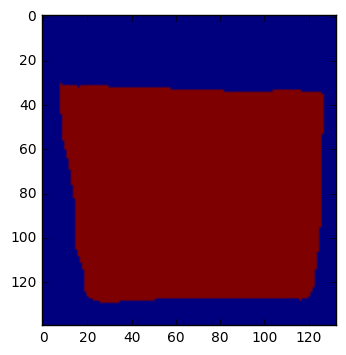

In [161]:
plt.imshow(fcis_part_all[0][0])
print(fcis_part_label_all[0][0])
print(fcis_part_score_all[0][0])

In [100]:
#fcis_part_all = []
#fcis_part_label_all = []

gt_part_all = []
gt_part_label_all = []

In [102]:
idx= 0
for imgname in image_names:
    realname = imgname
    #fcis_img = cv2.imread(fcis_path+realname+'_mask.png', 1)
    gt_img = cv2.imread(gt_path+realname+'.png', 1)
    
    h = gt_img.shape[0]
    w = gt_img.shape[1]
    
    #if fcis_img == None:
    #   print("no fcis output")
    #   fcis_img =  np.zeros(gt_img.shape,np.uint8)
        
    idx = idx+1
    print(str(idx) + " " + imgname) 
    
    #fcis_part,fcis_part_label = ParseMask(fcis_img,h,w)
    gt_part,gt_part_label = ParseMask(gt_img,h,w)

    #fcis_part_all.append(fcis_part)
    #fcis_part_label_all.append(fcis_part_label)
    
    gt_part_all.append(gt_part)
    gt_part_label_all.append(gt_part_label)

1 bal_00003
2 bal_00007
3 bal_00010
4 bal_00011
5 bal_00013
6 bal_00024
7 bal_00028
8 bal_00029
9 bal_00030
10 bal_00032
11 bal_00036
12 bal_00044
13 bal_00046
14 bal_00051
15 bal_00056
16 bal_00058
17 bal_00059
18 bal_00060
19 bal_00067
20 bal_00070
21 bal_00074
22 bal_00075
23 bal_00083
24 bal_00086
25 bal_00090
26 bal_00095
27 bal_00097
28 bal_00098
29 bal_00101
30 bal_00106
31 bal_00110
32 bal_00113
33 bal_00116
34 bal_00120
35 bal_00124
36 bal_00135
37 bal_00137
38 bal_00142
39 bal_00144
40 bal_00147
41 bal_00148
42 bal_00150
43 bal_00152
44 bal_00154
45 bla_00003
46 bla_00007
47 bla_00010
48 bla_00014
49 bla_00017
50 bla_00019
51 bla_00020
52 bla_00023
53 bla_00029
54 bla_00031
55 bla_00033
56 bla_00034
57 bla_00044
58 bla_00045
59 bla_00047
60 bla_00048
61 bla_00051
62 bla_00052
63 bla_00053
64 bla_00059
65 bla_00060
66 bla_00061
67 bla_00063
68 bla_00065
69 bla_00070
70 bla_00074
71 bla_00075
72 bla_00077
73 bla_00079
74 bla_00086
75 bla_00089
76 bla_00090
77 bla_00091
78 bla_0

595 cub_00437
596 cub_00438
597 cub_00440
598 cub_00441
599 cub_00445
600 cub_00448
601 cub_00451
602 cub_00456
603 cub_00460
604 cub_00466
605 cub_00471
606 cub_00474
607 cub_00477
608 cub_00478
609 cub_00480
610 cub_00482
611 cub_00486
612 cub_00493
613 cub_00498
614 cub_00499
615 cub_00500
616 cub_00501
617 cub_00504
618 cub_00512
619 cub_00517
620 cub_00519
621 cub_00521
622 cub_00527
623 cub_00528
624 cub_00529
625 cub_00532
626 cub_00534
627 cub_00539
628 cub_00543
629 cub_00544
630 cub_00549
631 cub_00561
632 cub_00564
633 cub_00569
634 cub_00572
635 cub_00578
636 cub_00580
637 cub_00581
638 cub_00585
639 cub_00587
640 cub_00591
641 cub_00601
642 cub_00606
643 cub_00607
644 cub_00608
645 cub_00609
646 cub_00613
647 cub_00615
648 cub_00620
649 cub_00622
650 cub_00626
651 cub_00627
652 cub_00631
653 cub_00642
654 cub_00645
655 cub_00647
656 cub_00652
657 cub_00653
658 cub_00654
659 cub_00659
660 cub_00660
661 cub_00670
662 cub_00674
663 cub_00677
664 cub_00678
665 cub_00679
666 cu

1167 cylinder_00093
1168 cylinder_00095
1169 cylinder_00100
1170 cylinder_00102
1171 cylinder_00103
1172 cylinder_00108
1173 cylinder_00113
1174 cylinder_00115
1175 cylinder_00117
1176 cylinder_00119
1177 cylinder_00121
1178 cylinder_00122
1179 cylinder_00124
1180 cylinder_00125
1181 cylinder_00131
1182 cylinder_00135
1183 cylinder_00138
1184 cylinder_00139
1185 cylinder_00141
1186 cylinder_00149
1187 cylinder_00151
1188 cylinder_00153
1189 cylinder_00154
1190 cylinder_00155
1191 cylinder_00156
1192 cylinder_00160
1193 cylinder_00164
1194 cylinder_00167
1195 cylinder_00177
1196 cylinder_00179
1197 cylinder_00182
1198 cylinder_00187
1199 cylinder_00188
1200 cylinder_00189
1201 cylinder_00190
1202 cylinder_00191
1203 cylinder_00198
1204 cylinder_00202
1205 cylinder_00205
1206 cylinder_00206
1207 cylinder_00212
1208 cylinder_00217
1209 cylinder_00224
1210 cylinder_00229
1211 cylinder_00231
1212 cylinder_00236
1213 cylinder_00239
1214 cylinder_00242
1215 cylinder_00244
1216 cylinder_00248


1582 cylinder_01459
1583 cylinder_01463
1584 cylinder_01464
1585 cylinder_01468
1586 cylinder_01471
1587 cylinder_01472
1588 cylinder_01475
1589 cylinder_01481
1590 cylinder_01489
1591 cylinder_01490
1592 cylinder_01491
1593 cylinder_01495
1594 cylinder_01497
1595 cylinder_01500
1596 cylinder_01502
1597 cylinder_01511
1598 cylinder_01513
1599 cylinder_01514
1600 cylinder_01517
1601 cylinder_01519
1602 cylinder_01521
1603 cylinder_01523
1604 cylinder_01527
1605 cylinder_01528
1606 cylinder_01530
1607 cylinder_01537
1608 cylinder_01538
1609 cylinder_01546
1610 cylinder_01554
1611 cylinder_01558
1612 cylinder_01559
1613 cylinder_01568
1614 cylinder_01569
1615 cylinder_01571
1616 cylinder_01580
1617 cylinder_01582
1618 cylinder_01586
1619 cylinder_01589
1620 cylinder_01593
1621 cylinder_01594
1622 cylinder_01602
1623 cylinder_01604
1624 cylinder_01608
1625 cylinder_01611
1626 cylinder_01612
1627 cylinder_01617
1628 cylinder_01621
1629 cylinder_01626
1630 cylinder_01630
1631 cylinder_01631


1992 cylinder_02813
1993 cylinder_02818
1994 cylinder_02819
1995 cylinder_02823
1996 cylinder_02826
1997 cylinder_02834
1998 cylinder_02837
1999 cylinder_02838
2000 cylinder_02842
2001 cylinder_02843
2002 cylinder_02847
2003 cylinder_02851
2004 cylinder_02854
2005 cylinder_02858
2006 cylinder_02861
2007 cylinder_02864
2008 cylinder_02865
2009 cylinder_02883
2010 cylinder_02885
2011 cylinder_02886
2012 cylinder_02888
2013 cylinder_02890
2014 cylinder_02893
2015 cylinder_02899
2016 cylinder_02900
2017 cylinder_02901
2018 cylinder_02902
2019 cylinder_02905
2020 cylinder_02909
2021 cylinder_02915
2022 cylinder_02917
2023 cylinder_02920
2024 cylinder_02923
2025 cylinder_02925
2026 cylinder_02927
2027 cylinder_02928
2028 cylinder_02929
2029 cylinder_02931
2030 cylinder_02935
2031 cylinder_02938
2032 cylinder_02940
2033 cylinder_02944
2034 cylinder_02953
2035 cylinder_02956
2036 cylinder_02957
2037 cylinder_02958
2038 cylinder_02961
2039 cylinder_02962
2040 cylinder_02963
2041 cylinder_02966


2497 tea_00115
2498 tea_00116
2499 tea_00117
2500 tea_00123
2501 tea_00127
2502 tea_00132
2503 tea_00135
2504 tea_00145
2505 tea_00148
2506 tea_00156
2507 tea_00157
2508 tea_00160
2509 tea_00161
2510 tea_00169
2511 tea_00172
2512 tea_00173
2513 tea_00179
2514 tea_00182
2515 tea_00183
2516 tea_00184
2517 tea_00188
2518 tea_00189
2519 tea_00192
2520 tea_00196
2521 tea_00200
2522 tea_00201
2523 tea_00210
2524 tea_00217
2525 tea_00218
2526 tea_00219
2527 tea_00220
2528 tea_00222
2529 tea_00227
2530 tea_00228
2531 tea_00233
2532 tea_00239
2533 tea_00240
2534 tea_00241
2535 tea_00251
2536 tea_00253
2537 tea_00254
2538 tea_00262
2539 tea_00264
2540 tea_00274
2541 tea_00276
2542 tea_00277
2543 tea_00290
2544 tea_00292
2545 tea_00296
2546 tea_00297
2547 tea_00314
2548 tea_00315
2549 tea_00318
2550 tea_00319
2551 tea_00320
2552 tea_00321
2553 tea_00324
2554 tea_00326
2555 tea_00329
2556 tea_00335
2557 tea_00342
2558 tea_00343
2559 tea_00347
2560 tea_00350
2561 tea_00351
2562 tea_00352
2563 tea_0

3025 cube_00899
3026 cube_00903
3027 cube_00907
3028 cube_00908
3029 cube_00909
3030 cube_00910
3031 cube_00912
3032 cube_00913
3033 cube_00918
3034 cube_00925
3035 cube_00931
3036 cube_00932
3037 cube_00936
3038 cube_00938
3039 cube_00939
3040 cube_00944
3041 cube_00948
3042 cube_00950
3043 cube_00951
3044 cube_00955
3045 cube_00957
3046 cube_00967
3047 cube_00968
3048 cube_00971
3049 cube_00975
3050 cube_00977
3051 cube_00978
3052 cube_00981
3053 cube_00982
3054 cube_00983
3055 cube_00985
3056 cube_00995
3057 cube_00996
3058 cube_00997
3059 cube_01001
3060 cube_01003
3061 cube_01005
3062 cube_01008
3063 cube_01010
3064 cube_01012
3065 cube_01015
3066 cube_01019
3067 cube_01036
3068 cube_01040
3069 cube_01041
3070 cube_01044
3071 cube_01045
3072 cube_01047
3073 cube_01048
3074 cube_01049
3075 cube_01059
3076 cube_01060
3077 cube_01061
3078 cube_01064
3079 cube_01072
3080 cube_01075
3081 cube_01078
3082 cube_01080
3083 cube_01086
3084 cube_01089
3085 cube_01091
3086 cube_01100
3087 cub

In [53]:
###################################################################

In [162]:
##########################################backup variables just in case
print(len(fcis_part_all))
print(len(gt_part_all))

print(len(fcis_list))
print(len(gt_list))

fcis_part_backup = fcis_part_all[:]
gt_part_backup = gt_part_all[:]
fcis_label_backup = fcis_part_label_all[:]
gt_label_backup = gt_part_label_all[:]

3474
3474
3465
3474


In [103]:
def GetPKLline(part,part_label,imgname,cls_name):    
    det_line = []
    seg_line = []
        
    for i in range(0,len(part)):
        oneclass = part_label[i]
        if oneclass == cls_name:
            #realname = imgname
            #queryfolder = fcis_path[:len(fcis_path)-1] +'_SCORE/' + oneclass +'/'
            #queryname = realname +'_'+ '*'+ '.npy'  
            #matches = list(search_file(queryname,queryfolder))
            #score = FetchScore(matches,part[i])

            inst,box = bbox(part[i])
            temp = np.zeros(5)
            temp[0:4] = box
            temp[-1] = 1.0

            #inst = cv2.resize(inst.astype(np.float32), (21,21))
            #plt.figure()
            #plt.imshow(inst)
            #inst[inst>0] = 1
            #plt.figure()
            #plt.imshow(inst)
            inst = np.array(inst)
            
            det_line.append(temp)
            seg_line.append(inst)
        
    return det_line,seg_line

In [104]:
for j in range(0,len(classes)):
    det_file = []
    seg_file = []
    print(classes.get(j))
    for i in range(0,len(gt_part_all)):
        part = gt_part_all[i]
        part_label = gt_part_label_all[i]
        det_line,seg_line= GetPKLline(part,part_label,image_names[i],classes.get(j))
        
        #if len(det_line)>0 and len(seg_line)>0:
        det_file.append(det_line)
        seg_file.append(seg_line)
    
    output_det = open(gt_path + classes.get(j)+'_det.pkl','wb')
    pickle.dump(det_file,output_det)
    output_det.close()
    
    output_seg = open(gt_path + classes.get(j)+'_seg.pkl','wb')
    pickle.dump(seg_file,output_seg)
    output_seg.close()

CubeBody
CubeFace
CylinderBody
CylinderFace


In [54]:
#from save_ipython_variables import load_all_variables, save_variable  
#save_variable('fcis_part_all', fcis_part_all)  
#save_variable('fcis_part_label_all', fcis_part_label_all)  
#save_variable('geonet_part_all', geonet_part_all)  
#save_variable('geonet_part_label_all', geonet_part_label_all)  
#save_variable('gt_part_all', gt_part_all)  
#save_variable('gt_part_label_all', gt_part_label_all)'''
#load_all_variables()

In [204]:
ov_thresh = 0.7   #overlap_threshold - 0.5/0.7....

In [205]:
#######################################################FCIS
all_tp = [[],[],[],[],[]]
all_fp = [[],[],[],[],[]]
overlap_areas = [[],[],[],[],[]]
all_scores = [[],[],[],[],[]]
gt_cls_num = np.zeros(num_classes)

for oneclass in range(0,num_classes):
    print(classes.get(oneclass))
    #find all instances in this class
    for i in range(0,len(fcis_part_all)):
        if i %1000 == 0:
            print(i)
        part = fcis_part_all[i]
        part_label = fcis_part_label_all[i]
        part_score = fcis_part_score_all[i]
        
        gt_part = gt_part_all[i]
        gt_part_label = gt_part_label_all[i]
        
        this_cls =  classes.get(oneclass)
        if this_cls in part_label:
            tp, fp , ov_areas , scores ,gt_thiscls_num= GetAP(part,part_label,part_score,gt_part,gt_part_label,oneclass,gt_list[i])
            #print(scores)
            #print(ov_areas)
            all_tp[oneclass].extend(tp)
            all_fp[oneclass].extend(fp)
            overlap_areas[oneclass].extend(ov_areas)
            all_scores[oneclass].extend(scores)
            gt_cls_num[oneclass] = gt_cls_num[oneclass] + gt_thiscls_num

CubeBody
0


UnboundLocalError: local variable 'i' referenced before assignment

In [181]:
print(len(overlap_areas[0]))
print(len(fcis_part_all))

1917
3474


In [197]:
for oneclass in range(0,num_classes):
    start = 0
    idx = 0
    for i in range(0,len(fcis_part_label_all)):
        inst_count = len(fcis_part_all[i])
        for k in range(0,inst_count):
            if fcis_part_label_all[i][k] == classes.get(oneclass):
                print(image_names[i]+" " +classes.get(oneclass)+ " " + str(all_scores[oneclass][idx]))
                idx = idx+1
        #part = fcis_part_all[i]
        #part_label = fcis_part_label_all[i]
        #part_score = fcis_part_score_all[i]

bal_00003 CubeBody 0.999640226364
bal_00007 CubeBody 0.999501109123
bal_00010 CubeBody 0.99930536747
bal_00011 CubeBody 0.991899490356
bal_00011 CubeBody 0.999377429485
bal_00013 CubeBody 0.984960615635
bal_00024 CubeBody 0.999739706516
bal_00028 CubeBody 0.993250668049
bal_00029 CubeBody 0.992014765739
bal_00030 CubeBody 0.999759972095
bal_00032 CubeBody 0.938344478607
bal_00036 CubeBody 0.999937176704
bal_00044 CubeBody 0.999898910522
bal_00046 CubeBody 0.981526434422
bal_00051 CubeBody 0.998712778091
bal_00056 CubeBody 0.99980789423
bal_00058 CubeBody 0.996231496334
bal_00059 CubeBody 0.998098790646
bal_00060 CubeBody 0.995298326015
bal_00067 CubeBody 0.771927177906
bal_00067 CubeBody 0.724298000336
bal_00067 CubeBody 0.724043011665
bal_00067 CubeBody 0.706782281399
bal_00070 CubeBody 0.999536752701
bal_00074 CubeBody 0.995480775833
bal_00075 CubeBody 0.99986410141
bal_00083 CubeBody 0.999714553356
bal_00086 CubeBody 0.966974556446
bal_00086 CubeBody 0.994535446167
bal_00090 CubeBod

cube_00909 CubeBody 0.999687075615
cube_00910 CubeBody 0.999864459038
cube_00912 CubeBody 0.999956846237
cube_00913 CubeBody 0.988019764423
cube_00918 CubeBody 0.996206283569
cube_00925 CubeBody 0.989856481552
cube_00931 CubeBody 0.999920606613
cube_00932 CubeBody 0.999504208565
cube_00936 CubeBody 0.999530434608
cube_00938 CubeBody 0.995595633984
cube_00939 CubeBody 0.99970883131
cube_00944 CubeBody 0.999425888062
cube_00948 CubeBody 0.999703109264
cube_00950 CubeBody 0.999641776085
cube_00951 CubeBody 0.997830212116
cube_00955 CubeBody 0.998667001724
cube_00957 CubeBody 0.961699545383
cube_00967 CubeBody 0.996432423592
cube_00968 CubeBody 0.998242497444
cube_00971 CubeBody 0.97047328949
cube_00975 CubeBody 0.995889365673
cube_00977 CubeBody 0.999344646931
cube_00978 CubeBody 0.123252592981
cube_00981 CubeBody 0.999870300293
cube_00982 CubeBody 0.0279296692461
cube_00983 CubeBody 0.999894142151
cube_00985 CubeBody 0.985238671303
cube_00995 CubeBody 0.999898314476
cube_00996 CubeBody 0

bow_00139 CylinderBody 0.00557645410299
bow_00141 CylinderBody 0.990958333015
bow_00143 CylinderBody 0.995940327644
bow_00147 CylinderBody 0.996273040771
bow_00152 CylinderBody 0.960266947746
bow_00155 CylinderBody 0.997703492641
bow_00161 CylinderBody 0.994705736637
bow_00164 CylinderBody 0.994975447655
bow_00166 CylinderBody 0.99738663435
bow_00168 CylinderBody 0.984274804592
bow_00169 CylinderBody 0.981359183788
bow_00169 CylinderBody 0.983763575554
bow_00171 CylinderBody 0.969074547291
bow_00180 CylinderBody 0.98811674118
bow_00180 CylinderBody 0.944116055965
bow_00183 CylinderBody 0.988044679165
bow_00185 CylinderBody 0.989672422409
bow_00189 CylinderBody 0.995888769627
bow_00195 CylinderBody 0.974703252316
bow_00196 CylinderBody 0.953081607819
box_00042 CylinderBody 0.0
box_00145 CylinderBody 0.0
box_00229 CylinderBody 0.0
box_00229 CylinderBody 0.0
box_00370 CylinderBody 0.0
box_00395 CylinderBody 0.0
box_00423 CylinderBody 0.0
cha_00001 CylinderBody 0.947000682354
cha_00007 Cyl

jui_00151 CylinderBody 0.996925652027
jui_00151 CylinderBody 0.990670323372
jui_00151 CylinderBody 0.99674475193
jui_00153 CylinderBody 0.826213717461
jui_00153 CylinderBody 0.995840847492
jui_00160 CylinderBody 0.994669854641
jui_00160 CylinderBody 0.996491372585
jui_00160 CylinderBody 0.996591806412
jui_00160 CylinderBody 0.996606111526
jui_00161 CylinderBody 0.998042941093
jui_00161 CylinderBody 0.968678295612
jui_00170 CylinderBody 0.997512578964
jui_00172 CylinderBody 0.767396867275
jui_00172 CylinderBody 0.996327459812
jui_00173 CylinderBody 0.998770534992
jui_00173 CylinderBody 0.773068785667
jui_00176 CylinderBody 0.998509466648
jui_00176 CylinderBody 0.982190728188
jui_00177 CylinderBody 0.986873567104
jui_00177 CylinderBody 0.994985938072
jui_00177 CylinderBody 0.920539617538
jui_00177 CylinderBody 0.9515234828
jui_00185 CylinderBody 0.998773038387
jui_00188 CylinderBody 0.96617770195
jui_00188 CylinderBody 0.15706974268
jui_00189 CylinderBody 0.986600339413
jui_00189 Cylinde

cylinder_01350 CylinderFace 0.998013973236
cylinder_01353 CylinderFace 0.900693893433
cylinder_01353 CylinderFace 0.971108496189
cylinder_01354 CylinderFace 0.999397516251
cylinder_01354 CylinderFace 0.977063477039
cylinder_01357 CylinderFace 0.976219236851
cylinder_01358 CylinderFace 0.837046146393
cylinder_01363 CylinderFace 0.714809060097
cylinder_01366 CylinderFace 0.997402369976
cylinder_01368 CylinderFace 0.88714069128
cylinder_01368 CylinderFace 0.914339005947
cylinder_01373 CylinderFace 0.783732771873
cylinder_01373 CylinderFace 0.93205344677
cylinder_01373 CylinderFace 0.00876877456903
cylinder_01375 CylinderFace 0.963215172291
cylinder_01380 CylinderFace 0.771014750004
cylinder_01380 CylinderFace 0.822492539883
cylinder_01380 CylinderFace 0.826979100704
cylinder_01380 CylinderFace 0.955645859241
cylinder_01382 CylinderFace 0.852206408978
cylinder_01382 CylinderFace 0.8764295578
cylinder_01396 CylinderFace 0.995367288589
cylinder_01396 CylinderFace 0.984411001205
cylinder_0139

In [164]:
ap = np.zeros(num_classes)
for oneclass in range(0,num_classes):
    
    ####### 按照score重新对tp 和 fp 排序
    orderidx = np.argsort(all_scores[oneclass])
    orderidx = orderidx[::-1]
    tps_backup = all_tp[oneclass][:]
    fpt_backup = all_fp[oneclass][:]
    or_tps = []
    or_fps = []
    for x in orderidx:
        or_tps.append(all_tp[oneclass][x])
        or_fps.append(all_fp[oneclass][x])
        one_tp = or_tps[:]
        one_fp = or_fps[:]
    ##################################

    #one_tp = all_tp[oneclass]
    #one_fp = all_fp[oneclass]
    
    num_pos = gt_cls_num[oneclass]
    one_tp = np.cumsum(one_tp)
    one_fp = np.cumsum(one_fp)
    rec = one_tp / np.maximum(float(num_pos),  np.finfo(np.float64).eps)
    #avoid divide by zero in case the first matches a difficult gt
    prec = one_tp / np.maximum(one_fp+one_tp, np.finfo(np.float64).eps)
    ap[oneclass] = voc_ap(rec, prec, True)
print('FCIS')
print('~~~~~~~~~~~~~~~~~~~~~~~')
mAP = 0.0
for oneclass in range(0,num_classes):
    mAP+=ap[oneclass]
    print('AP for ' + classes.get(oneclass) +" =  " + str(ap[oneclass]*100))
    
print('~~~~~~~~~~~~~~~~~~~~~~~')
mAP /= num_classes
print('Mean AP@' + str(ov_thresh) +' = ' + str(mAP*100))

FCIS
~~~~~~~~~~~~~~~~~~~~~~~
AP for CubeBody =  68.497093841
AP for CubeFace =  69.333951221
AP for CylinderBody =  49.6763609135
AP for CylinderFace =  38.33649431
~~~~~~~~~~~~~~~~~~~~~~~
Mean AP@0.7 = 56.4609750714


In [46]:
fcis_dcn_noss_score_backup = all_scores[:]
fcis_dcn_noss_part = fcis_part_all[:]
fcis_dcn_noss_part_label = fcis_part_label_all[:]
fcis_dcn_noss_tp_5 = all_tp[:]
fcis_dcn_noss_fp_5 = all_fp[:]

In [70]:
############################################################################
####save each instance as images

In [26]:
def save_inst(fcis_part_all,fcis_part_label_all,folder):
    os.mkdir(folderpath+folder)
    for i in range(0,len(fcis_part_all)):
        imgname = img_names[i]
        oneimg = fcis_part_all[i]
        oneimg_label = fcis_part_label_all[i]
        for j in range(0,len(oneimg)):
            inst = oneimg[j]
            inst[inst>=1] = 255
            inst_label = oneimg_label[j]
            name = imgname
            filename = folderpath +folder+'/'+ name + '_'+str(j)+'_' + inst_label +'.png'
            print(filename)
            cv2.imwrite(filename, inst)

In [28]:
img_names = image_names
#save_inst(gt_part_all,gt_part_label_all,'gt_split')
#save_inst(fcis_part_all,fcis_part_label_all,'fcis_split')
save_inst(fcis_part_all,fcis_part_label_all,'fcis_dcn_noss_split')

Exper_FCIS_DCN/fcis_dcn_noss_split/bal_00003_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/bal_00003_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/bal_00007_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/bal_00007_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/bal_00010_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/bal_00010_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/bal_00010_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/bal_00010_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/bal_00011_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/bal_00011_1_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/bal_00011_2_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/bal_00011_3_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/bal_00013_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/bal_00013_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/bal_00013_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/bal_00024_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss

Exper_FCIS_DCN/fcis_dcn_noss_split/bla_00195_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/bla_00195_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/bla_00195_2_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/bla_00202_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/bla_00202_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/bla_00209_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/bla_00209_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/bla_00211_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/bla_00211_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/bla_00213_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/bla_00213_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/bla_00215_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/bla_00215_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/bla_00217_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/bla_00217_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/bow_00004_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/b

Exper_FCIS_DCN/fcis_dcn_noss_split/box_00177_2_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/box_00184_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/box_00184_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/box_00185_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/box_00185_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/box_00189_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/box_00189_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/box_00192_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/box_00192_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/box_00210_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/box_00210_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/box_00212_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/box_00212_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/box_00213_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/box_00213_1_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/box_00213_2_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/box_0

Exper_FCIS_DCN/fcis_dcn_noss_split/cha_00087_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cha_00087_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cha_00087_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cha_00088_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cha_00088_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cha_00088_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cha_00091_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cha_00091_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cha_00091_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cha_00091_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cha_00091_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cha_00091_5_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cha_00091_6_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cha_00091_7_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cha_00091_8_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cha_0

Exper_FCIS_DCN/fcis_dcn_noss_split/cha_00301_5_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cha_00307_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cha_00307_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cha_00307_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cha_00307_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cha_00307_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cha_00307_5_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cha_00315_0_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cha_00315_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cha_00315_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cha_00318_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cha_00318_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cha_00318_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cha_00321_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cha_00321_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cha_00321

Exper_FCIS_DCN/fcis_dcn_noss_split/cub_00222_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_00223_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_00223_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_00224_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_00224_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_00231_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_00231_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_00233_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_00233_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_00238_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_00238_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_00240_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_00240_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_00243_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_00243_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_00244_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_0

Exper_FCIS_DCN/fcis_dcn_noss_split/cub_00512_0_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_00512_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_00517_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_00517_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_00519_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_00519_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_00521_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_00521_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_00527_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_00527_1_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_00527_2_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_00528_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_00528_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_00529_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_00529_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_00532_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_spl

Exper_FCIS_DCN/fcis_dcn_noss_split/cub_01020_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_01022_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_01022_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_01031_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_01031_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_01031_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_01033_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_01033_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_01035_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_01035_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_01042_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_01042_1_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_01042_2_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_01042_3_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_01042_4_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_01042_5_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/c

Exper_FCIS_DCN/fcis_dcn_noss_split/cub_01469_22_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_01469_23_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_01480_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_01480_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_01485_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_01485_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_01485_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_01487_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_01487_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_01487_2_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_01491_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_01491_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_01493_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_01493_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_01493_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cub_01496_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_s

Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00121_3_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00121_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00121_5_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00121_6_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00121_7_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00124_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00124_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00124_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00124_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00127_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00127_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00127_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00127_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00128_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00128_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_0

Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00310_8_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00311_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00311_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00311_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00311_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00311_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00314_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00314_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00314_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00314_3_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00314_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00314_5_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00314_6_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00316_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00316_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_0

Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00474_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00476_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00476_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00476_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00486_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00486_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00486_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00486_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00490_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00490_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00490_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00490_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00490_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00490_5_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_00491_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cup_0

Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00022_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00022_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00022_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00022_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00022_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00026_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00026_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00026_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00026_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00026_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00027_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00027_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00027_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00027_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split

Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00198_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00198_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00198_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00198_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00198_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00202_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00202_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00202_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00202_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00202_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00205_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00205_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00205_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00205_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split

Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00440_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00440_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00440_3_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00441_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00441_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00441_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00441_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00441_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00441_5_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00442_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00442_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00442_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00446_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00446_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cyl

Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00640_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00643_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00643_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00646_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00646_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00647_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00647_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00647_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00649_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00649_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00649_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00649_3_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00650_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00651_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00651_

Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00831_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00833_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00833_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00833_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00833_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00833_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00838_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00838_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00839_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00839_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00839_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00844_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00844_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00844_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cyl

Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00940_3_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00940_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00946_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00946_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00946_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00947_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00947_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00947_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00954_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00954_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00954_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00954_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00955_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_00955_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split

Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01059_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01059_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01059_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01059_3_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01059_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01059_5_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01059_6_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01059_7_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01062_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01062_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01062_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01062_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01062_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01062_5_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split

Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01305_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01305_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01305_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01307_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01307_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01307_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01307_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01309_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01309_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01309_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01316_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01316_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01316_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01316_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split

Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01530_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01530_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01530_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01537_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01537_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01537_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01537_3_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01537_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01537_5_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01537_6_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01537_7_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01538_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01538_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01546_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split

Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01634_7_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01638_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01638_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01638_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01642_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01642_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01642_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01646_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01646_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01646_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01646_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01648_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01648_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01648_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split

Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01801_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01801_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01801_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01801_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01803_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01803_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01803_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01803_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01804_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01804_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01805_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01805_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01805_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01805_3_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cyl

Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01932_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01932_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01932_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01933_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01941_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01941_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01941_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01941_3_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01941_4_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01941_5_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01941_6_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01941_7_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01941_8_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_01941_9_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split

Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02067_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02067_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02067_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02067_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02067_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02069_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02069_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02069_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02069_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02069_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02069_5_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02069_6_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02069_7_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02072_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split

Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02173_6_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02174_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02174_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02174_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02174_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02174_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02174_5_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02174_6_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02174_7_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02174_8_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02174_9_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02177_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02177_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02177_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split

Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02335_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02335_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02336_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02336_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02336_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02336_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02338_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02338_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02338_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02341_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02341_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02341_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02341_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02341_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split

Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02442_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02442_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02446_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02446_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02446_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02446_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02446_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02446_5_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02446_6_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02449_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02449_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02449_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02449_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02452_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split

Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02629_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02629_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02629_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02635_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02635_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02635_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02635_3_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02635_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02636_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02636_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02641_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02641_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02641_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02641_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cyl

Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02800_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02800_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02800_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02803_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02803_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02803_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02803_3_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02803_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02807_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02807_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02807_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02807_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02807_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02810_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split

Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02893_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02893_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02899_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02899_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02899_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02900_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02900_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02900_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02901_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02901_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02901_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02901_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02902_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_02902_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split

Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_03120_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_03120_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_03130_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_03130_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_03130_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_03137_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_03137_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_03138_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_03138_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_03140_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_03140_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_03140_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_03143_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinder_03143_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cylinde

Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00007_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00007_3_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00007_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00007_5_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00007_6_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00007_7_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00008_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00008_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00008_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00008_3_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00008_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00008_5_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00008_6_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00011_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00011_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_0

Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00244_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00244_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00244_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00244_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00245_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00245_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00245_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00245_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00245_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00246_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00246_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00246_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00246_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00246_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00248_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_0

Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00494_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00497_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00497_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00497_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00510_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00510_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00510_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00518_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00518_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00518_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00518_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00518_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00528_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00528_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/jui_00528_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/lov_0

Exper_FCIS_DCN/fcis_dcn_noss_split/lov_00284_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/lov_00284_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/lov_00284_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/lov_00284_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/lov_00284_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/lov_00291_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/lov_00291_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/lov_00291_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/lov_00291_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/lov_00291_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/lov_00292_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/lov_00292_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/lov_00292_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/lov_00292_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/lov_00292_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/lov_0

Exper_FCIS_DCN/fcis_dcn_noss_split/tea_00043_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/tea_00043_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/tea_00043_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/tea_00054_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/tea_00054_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/tea_00054_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/tea_00054_3_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/tea_00054_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/tea_00054_5_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/tea_00059_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/tea_00059_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/tea_00059_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/tea_00059_3_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/tea_00059_4_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/tea_00059_5_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/tea_0

Exper_FCIS_DCN/fcis_dcn_noss_split/tea_00296_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/tea_00296_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/tea_00296_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/tea_00296_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/tea_00297_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/tea_00297_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/tea_00297_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/tea_00297_3_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/tea_00297_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/tea_00297_5_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/tea_00314_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/tea_00314_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/tea_00314_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/tea_00314_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/tea_00314_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/tea_0

Exper_FCIS_DCN/fcis_dcn_noss_split/vas_00036_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/vas_00036_5_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/vas_00038_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/vas_00038_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/vas_00038_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/vas_00039_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/vas_00039_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/vas_00039_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/vas_00044_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/vas_00044_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/vas_00044_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/vas_00044_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/vas_00056_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/vas_00056_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/vas_00056_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/vas_0

Exper_FCIS_DCN/fcis_dcn_noss_split/vas_00307_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/vas_00307_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/vas_00307_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/vas_00313_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/vas_00313_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/vas_00315_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/vas_00315_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/vas_00315_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/vas_00319_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/vas_00319_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/vas_00319_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/vas_00319_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/vas_00319_4_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/vas_00319_5_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/vas_00321_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/vas_0

Exper_FCIS_DCN/fcis_dcn_noss_split/cube_00246_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_00246_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_00246_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_00246_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_00247_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_00247_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_00250_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_00250_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_00251_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_00251_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_00256_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_00262_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_00262_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_00266_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_00266_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_00268_0_CubeBody.png
Exper_FCIS_DCN/f

Exper_FCIS_DCN/fcis_dcn_noss_split/cube_01585_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_01585_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_01586_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_01586_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_01591_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_01595_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_01595_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_01602_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_01602_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_01602_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_01606_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_01606_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_01609_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_01609_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_01617_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_01621_0_CubeBody.png
Exper_FCIS_DCN/f

Exper_FCIS_DCN/fcis_dcn_noss_split/cube_01930_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_01931_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_01931_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_01933_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_01933_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_01945_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_01945_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_01946_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_01946_1_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_01946_2_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_01946_3_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_01946_4_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_01947_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_01947_1_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_01947_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_01947_3_Cylin

Exper_FCIS_DCN/fcis_dcn_noss_split/cube_02127_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_02127_1_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_02127_2_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_02128_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_02128_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_02131_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_02131_1_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_02131_2_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_02131_3_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_02131_4_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_02131_5_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_02134_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_02134_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_02135_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_02135_1_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_02135_2_CubeBody.png
Exper_FCIS_DCN/f

Exper_FCIS_DCN/fcis_dcn_noss_split/cube_02402_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_02413_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_02414_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_02414_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_02414_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_02415_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_02420_0_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_02423_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_02423_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_02426_0_CubeBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_02426_1_CubeFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_02426_2_CylinderBody.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_02426_3_CylinderFace.png
Exper_FCIS_DCN/fcis_dcn_noss_split/cube_02426_4_CylinderFace.png


In [ ]:
#########################################################

In [ ]:
##############################################################################
####save per image overlap

In [23]:
def PerImageOV(part,label,gt_part,gt_label):
    # part is one image
    ov = np.zeros(len(part))
    gt_detect_list = np.zeros(len(gt_part))
    for i in range(0,len(part)):
        cur_overlap = -1000
        curr_overlap_idx = -1
        for j in range(0,len(gt_part)):
            if gt_label[j] == label[i]:
                ovv = mask_overlap(gt_part[j], part[i])
                if ovv > cur_overlap:
                    cur_overlap = ovv
                    curr_overlap_idx = j
        if cur_overlap == -1000:
            ov[i] = 0
        else:
            if gt_detect_list[curr_overlap_idx]==0:
                ov[i] = cur_overlap
                gt_detect_list[curr_overlap_idx]==1
            else:
                ov[i] = 0
    return ov

In [24]:
counter = 0
fcis_mean_ov = 0
for i in range(0,len(fcis_part_all)):
    #print(i)
    ov = PerImageOV(fcis_part_all[i],fcis_part_label_all[i],gt_part_all[i],gt_part_label_all[i])
    print(ov)
    for x in ov:
        counter = counter + 1
        fcis_mean_ov = x + fcis_mean_ov    
    #filename = fcis_list[i]
    #savefile(folderpath+'fcis/'+filename[:filename.index('.')]+'.txt',ov)

[ 0.65633475  0.        ]
[ 0.2268159]
[ 0.         0.         0.8578362]
[ 0.          0.83039648]
[ 0.854035    0.93994082  0.38944717]
[ 0.  0.  0.  0.  0.  0.]
[]
[ 0.]
[ 0.  0.]
[ 0.88254629]
[ 0.  0.  0.]
[ 0.]
[ 0.92394334  0.94042572]
[ 0.847061    0.42210667  0.49913993]
[ 0.93086817  0.9244508 ]
[ 0.88640174  0.9313855 ]
[ 0.78910798  0.89674101]
[ 0.94015342  0.89470025]
[ 0.76597422  0.71728992]
[ 0.82746927  0.88383205]
[ 0.]
[ 0.8146519   0.77155701]
[ 0.9117041   0.88244986]
[ 0.  0.  0.  0.]
[ 0.85152517  0.93329168]
[ 0.89063555  0.91015096  0.64011856  0.62854331]
[ 0.         0.         0.         0.6589698]
[ 0.  0.  0.]
[ 0.33955438  0.        ]
[ 0.92060165  0.94998108]
[ 0.87027353]
[ 0.61251139]
[ 0.94455703  0.93239158]
[ 0.76355113  0.        ]
[ 0.  0.]
[ 0.9565762   0.86868742]
[ 0.59809524  0.          0.79316338]
[ 0.  0.  0.]
[ 0.          0.          0.72402419]
[ 0.01028504  0.5402867   0.34503511]
[ 0.         0.1224391]
[ 0.  0.]
[ 0.          0.     

[ 0.10155908  0.57458162  0.66603641]
[ 0.]
[ 0.92564821  0.91039042]
[ 0.  0.]
[ 0.         0.         0.7237112]
[ 0.67974649]
[ 0.02078378]
[ 0.87783661  0.94946145]
[ 0.69981527  0.89473929]
[ 0.94463351  0.87895546]
[ 0.82978598  0.94060735]
[ 0.19965572]
[ 0.]
[ 0.         0.         0.8222406]
[ 0.75887691  0.90887393]
[ 0.          0.          0.          0.87526055]
[ 0.          0.79269016]
[ 0.          0.          0.84184823  0.          0.        ]
[ 0.87649078  0.82990084]
[ 0.94104301  0.00698617]
[ 0.89759937  0.68680472]
[ 0.  0.  0.]
[ 0.92302746  0.93367706]
[ 0.86221837  0.91172125]
[ 0.          0.          0.91698924]
[ 0.          0.          0.73590316  0.85227816]
[ 0.          0.          0.          0.69634862]
[ 0.  0.  0.]
[ 0.60495522  0.74917492  0.88497557  0.77192685  0.86723677]
[ 0.95093624  0.91757878]
[ 0.  0.  0.  0.]
[ 0.91440956  0.84293955]
[ 0.          0.89540059]
[ 0.8727133   0.72661576  0.05651309]
[ 0.          0.87123288]
[ 0.73638968  0.

[ 0.51156495  0.45092025  0.74352367]
[ 0.94719017  0.9388322 ]
[ 0.94292913  0.93241806]
[ 0.95178566  0.92226633]
[  8.74655225e-01   2.83173812e-05   8.89420035e-01]
[ 0.91938216  0.8758209 ]
[ 0.95246754  0.94283554]
[ 0.         0.         0.         0.4375975]
[ 0.  0.]
[ 0.  0.]
[ 0.94855352  0.95153506]
[]
[ 0.          0.          0.64415387  0.4673256 ]
[ 0.76178997  0.95211688]
[ 0.9506228   0.95422128]
[ 0.]
[]
[ 0.  0.]
[ 0.88014383  0.9265506 ]
[ 0.92721843  0.56935687]
[ 0.]
[ 0.]
[]
[ 0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.]
[ 0.  0.  0.]
[ 0.19944598  0.709458    0.75311651]
[ 0.90623726  0.96015969]
[ 0.]
[ 0.  0.]
[ 0.8462847   0.85456148  0.87501147  0.77202177]
[ 0.]
[ 0.         0.1135165  0.700625 ]
[ 0.714791    0.94154403]
[]
[ 0.56601307  0.921262  ]
[ 0.93829504  0.94664752]
[ 0.]
[ 0.88807683  0.88503399]
[ 0.89662677  0.90153779]
[ 0.94017592  0.91855726]
[ 0.  0.]
[ 0.          0.          0.80878534  0.70619776]
[ 0.50152905  0.96989308]
[ 0.  0.]
[ 0.      

[ 0.7474414  0.       ]
[ 0.  0.  0.]
[ 0.77809147  0.8394209 ]
[ 0.76689446  0.95078969]
[ 0.91211443  0.90409743]
[ 0.          0.          0.85770841]
[ 0.80995666  0.86959031]
[ 0.  0.]
[ 0.91961399  0.8989138 ]
[ 0.          0.          0.          0.92876929]
[ 0.          0.          0.90813911  0.9025695 ]
[ 0.  0.]
[ 0.43338584]
[ 0.91839992  0.89751027]
[ 0.92424242  0.94157759]
[ 0.68635494  0.83307573]
[ 0.]
[ 0.89973115  0.88770842]
[ 0.          0.          0.          0.          0.83943089  0.84099617]
[ 0.  0.  0.]
[ 0.09250109  0.07908376  0.        ]
[ 0.  0.  0.  0.]
[ 0.57659128  0.78664424]
[ 0.  0.]
[ 0.          0.          0.          0.76722133]
[ 0.95473428  0.9225923 ]
[ 0.86676893]
[ 0.          0.          0.79326701]
[ 0.93009915  0.8990954 ]
[ 0.76206724  0.84192298]
[ 0.77891216  0.71519443]
[ 0.]
[ 0.88989057  0.83071931]
[ 0.]
[ 0.8928278   0.02419001]
[ 0.90811674  0.9238002   0.73355956]
[ 0.94424278  0.95209903]
[ 0.]
[]
[ 0.91991716]
[ 0.91311086 

[ 0.         0.7245509  0.       ]
[]
[ 0.]
[ 0.          0.91034913]
[ 0.57729576  0.70288079]
[ 0.92450204  0.94273054]
[ 0.  0.]
[ 0.01378868  0.        ]
[ 0.  0.]
[ 0.87124464  0.91332888]
[ 0.71668956  0.          0.78964942]
[ 0.  0.]
[ 0.          0.          0.73170732]
[ 0.  0.]
[ 0.  0.  0.]
[]
[ 0.          0.          0.55234657]
[ 0.  0.  0.  0.]
[ 0.  0.  0.]
[ 0.90592972  0.63560034]
[ 0.91515391  0.92275208]
[ 0.  0.]
[ 0.73680782  0.92880863]
[ 0.54466403  0.90832063]
[ 0.          0.          0.82321188  0.82360529  0.          0.        ]
[ 0.93271462  0.95200259]
[ 0.19850352]
[ 0.]
[ 0.          0.83003184]
[ 0.00639397  0.09404117]
[]
[ 0.91136803  0.72253993]
[ 0.  0.  0.  0.]
[ 0.0068262   0.16074864]
[ 0.  0.  0.  0.  0.]
[ 0.84481715  0.94511246]
[ 0.          0.          0.82979452]
[ 0.          0.          0.4461057   0.38398177]
[ 0.91200342  0.90438717]
[ 0.92275997  0.93283344]
[]
[ 0.9265796   0.91712573]
[ 0.]
[ 0.          0.          0.80132309]
[ 0

[ 0.87894078  0.8874267 ]
[ 0.89177225  0.90034115]
[ 0.  0.  0.  0.  0.]
[ 0.          0.          0.87662338]
[ 0.          0.          0.93766748]
[ 0.00637329  0.64789916]
[ 0.]
[ 0.88757332  0.95193739]
[ 0.]
[ 0.]
[ 0.37053954  0.51176262  0.37768293]
[ 0.63302437  0.          0.70315351]
[ 0.          0.          0.92962543]
[ 0.92289955  0.74885702  0.88150782  0.7191458   0.8615643   0.88763258]
[ 0.91260722  0.80862149]
[ 0.77262149  0.          0.67006664  0.          0.91089947]
[]
[ 0.          0.          0.75246914  0.88694828]
[]
[ 0.73089802  0.9384072 ]
[ 0.75494816  0.6420729   0.          0.          0.          0.36423274
  0.38866279]
[ 0.85013624  0.81894021]
[ 0.70188391  0.          0.86446469]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.  0.]
[ 0.          0.          0.          0.          0.          0.          0.
  0.875       0.81377551  0.88832487  0.87556561]
[ 0.  0.]
[ 0.          0.          0.79094243]
[ 0.          0.          0.72613998]
[ 0.91149554  0.83335507

[ 0.92892114  0.94526564]
[ 0.  0.]
[ 0.          0.          0.          0.90333158]
[ 0.57931625  0.80592654  0.97060406]
[ 0.94293118  0.95381685]
[ 0.]
[ 0.         0.         0.         0.         0.         0.7486965]
[ 0.  0.  0.]
[ 0.          0.          0.66610169  0.65840708]
[ 0.90538807  0.92077857]
[ 0.          0.          0.56570672]
[ 0.  0.]
[ 0.82891285  0.93702165]
[ 0.  0.  0.]
[ 0.          0.8081903   0.77986023  0.          0.        ]
[]
[ 0.  0.]
[ 0.]
[ 0.  0.  0.]
[ 0.  0.  0.]
[ 0.76320378  0.63926262]
[ 0.56868795  0.91996927]
[ 0.  0.  0.]
[ 0.          0.92252102]
[ 0.  0.]
[ 0.          0.          0.62249428]
[ 0.90663043  0.87982011]
[ 0.66263007  0.78843534  0.8770201 ]
[ 0.          0.          0.69247432]
[ 0.          0.          0.          0.80246092]
[ 0.45883642]
[ 0.88525495  0.95039041]
[ 0.          0.          0.72433853]
[ 0.73413109  0.56024707]
[]
[ 0.93977901  0.95511487]
[ 0.90575472  0.7538137 ]
[ 0.  0.]
[]
[ 0.01156677  0.51925667]

[ 0.  0.  0.  0.  0.]
[ 0.001853    0.59153036]
[ 0.  0.  0.  0.]
[ 0.          0.          0.84961619]
[ 0.]
[ 0.  0.  0.]
[ 0.          0.76087336]
[ 0.78823529  0.88036847]
[ 0.90505695  0.88146796]
[ 0.83289538  0.9063426   0.65059113  0.78599171]
[ 0.          0.40802213  0.          0.48316062  0.83335949]
[ 0.90273849  0.88769656]
[ 0.88194052  0.        ]
[ 0.72163644  0.          0.        ]
[ 0.95771151  0.94213218]
[ 0.93356101  0.9375    ]
[ 0.8622975   0.85714286  0.83320979  0.90667945  0.86587302  0.88881748
  0.82972136  0.85577841  0.90193506  0.8896481 ]
[ 0.61584924]
[ 0.  0.]
[ 0.74279413  0.45008723]
[ 0.23742561  0.88627668]
[ 0.  0.  0.  0.]
[ 0.04948467]
[ 0.  0.]
[ 0.          0.          0.91693009]
[ 0.  0.]
[ 0.          0.62867012  0.59791123  0.          0.8608522 ]
[ 0.          0.          0.7538674   0.          0.75672737  0.
  0.55834464  0.77358491]
[ 0.          0.          0.78108652]
[ 0.91871567  0.70625541]
[ 0.  0.]
[ 0.  0.]
[ 0.51392703]
[ 0.

[ 0.94448617  0.94906612]
[ 0.87793255  0.90730306]
[ 0.]
[ 0.          0.          0.79432283]
[ 0.92432044  0.92424455]
[ 0.85330619]
[ 0.          0.          0.91778793]
[ 0.         0.6955267]
[ 0.95322456  0.90363563]
[ 0.85384869  0.91231793]
[ 0.80339335  0.52654806]
[ 0.91440589  0.94617429]
[ 0.85186979  0.90213261]
[ 0.83157895  0.92537961  0.81152153  0.7719797 ]
[ 0.          0.          0.79468098  0.60830527]
[ 0.2127712]
[ 0.36569482  0.50312278]
[ 0.          0.          0.76720383]
[ 0.01240038]
[ 0.  0.  0.]
[ 0.]
[ 0.96276052  0.96423643]
[ 0.          0.78810409]
[ 0.79832854  0.          0.81087342  0.92901054]
[ 0.  0.  0.  0.  0.  0.]
[ 0.85884597  0.93071805]
[ 0.  0.]
[ 0.82351852  0.54209919  0.87793081  0.71799333  0.92797235]
[ 0.          0.          0.69395263  0.71546547]
[ 0.92929964  0.94437931]
[ 0.90598925  0.9167005 ]
[ 0.          0.          0.          0.65132188]
[ 0.82921404  0.          0.        ]
[ 0.95041737  0.94935971]
[ 0.          0.   

[ 0.78132716  0.8264922   0.69468522  0.83168883  0.8421362   0.74149719]
[ 0.  0.  0.]
[ 0.715       0.43196106]
[ 0.  0.  0.]
[ 0.87429719  0.88167748]
[ 0.7856305   0.80138356]
[ 0.89557425]
[ 0.  0.  0.]
[ 0.9042525   0.79996946]
[ 0.64596162]
[ 0.          0.78891616  0.96494089]
[ 0.]
[ 0.          0.          0.49576562]
[ 0.          0.          0.86073574]
[]
[ 0.          0.57592154  0.64067914  0.          0.93242187]
[ 0.          0.70921986]
[ 0.          0.          0.          0.84041184]
[ 0.          0.          0.          0.91204589]
[ 0.          0.          0.91569628]
[ 0.          0.          0.38320995]
[ 0.  0.]
[ 0.          0.58657613]
[ 0.94001751  0.91963048]
[ 0.89592998  0.82428168]
[ 0.]
[ 0.          0.          0.83615085]
[ 0.  0.]
[ 0.92327044  0.81393868]
[ 0.  0.  0.  0.]
[ 0.  0.]
[ 0.          0.80327528  0.        ]
[ 0.22895395]
[ 0.          0.          0.71697866]
[ 0.          0.          0.          0.80041524  0.84874059]
[ 0.00230909  0. 

[ 0.95116755  0.91624638]
[ 0.93237864  0.92017536]
[ 0.94816812  0.93580229]
[ 0.          0.          0.58735699  0.76277017]
[ 0.76769626]
[]
[ 0.09248848]
[ 0.  0.  0.  0.  0.]
[ 0.          0.          0.53007519  0.82315064]
[ 0.90161991  0.95957011]
[ 0.78699734  0.90353644]
[ 0.]
[ 0.86582084  0.88249922]
[ 0.  0.  0.]
[ 0.          0.          0.70423163  0.68654482]
[ 0.00094829  0.86540711]
[ 0.93917949  0.90514517]
[ 0.93172578  0.93735172]
[ 0.49044869  0.        ]
[ 0.92724523  0.88268233]
[ 0.          0.          0.84434762]
[ 0.  0.]
[ 0.6471364]
[]
[ 0.4572532   0.42671255  0.81421791]
[ 0.91667617  0.95320901]
[ 0.  0.]
[ 0.80182232  0.96418323]
[ 0.]
[ 0.  0.]
[ 0.57180414  0.92933492]
[ 0.          0.          0.42039106]
[ 0.  0.]
[ 0.85567672  0.82210243]
[ 0.          0.          0.88313062]
[ 0.          0.          0.71010542]
[ 0.95969905  0.96537458]
[ 0.37102459  0.        ]
[ 0.90906314  0.92807902]
[ 0.91330588]
[ 0.          0.          0.73295198]
[ 0.7

In [25]:
print(fcis_mean_ov)
print(counter)
print(fcis_mean_ov/(2*counter))

3514.61452873
8355
0.210330013688


In [32]:
counter = 0
geonet_mean_ov = 0
imgovlist = []
for i in range(0,len(geonet_part_all)):
    #print(i)
    ov = PerImageOV(geonet_part_all[i],geonet_part_label_all[i],gt_part_all[i],gt_part_label_all[i])
    if 'CylinderBody' in geonet_part_label_all[i]:
        imgovlist.append(ov.mean())
        print(ov)
    else:
        imgovlist.append(0)
    for x in ov:
        counter = counter + 1
        geonet_mean_ov = x + geonet_mean_ov
        
    #filename = geonet_list[i]
    #savefile(folderpath+'geonet/'+filename[:filename.index('.')]+'.txt',ov)

[ 0.50966481  0.79569456  0.83667883  0.84591008]
[ 0.69959862  0.93715898  0.80275892]
[ 0.96122158  0.91028876]
[ 0.57677903  0.33146067  0.8300123   0.89010283  0.87571893  0.52678571
  0.74451411]
[ 0.60400407  0.90558369  0.71456486]
[ 0.03359986  0.          0.05113863  0.13390207]
[ 0.62285273  0.7975776   0.        ]
[ 0.80239521  0.93168626  0.81852753  0.51553484]
[ 0.92695288  0.74889734  0.82586922  0.8783952 ]
[ 0.63139932  0.37595908  0.79815016  0.42119565  0.86476523  0.
  0.04471545]
[ 0.0357922   0.8302583   0.88393852  0.57092496  0.00342857]
[ 0.93849613  0.60744451  0.66900621  0.72157153  0.        ]
[ 0.16779067  0.          0.89081747  0.87615601]
[ 0.67360645  0.81848875  0.01775457  0.97279811  0.86763479  0.74743076]
[ 0.57436276  0.69156515]
[ 0.63009404  0.76841778  0.70883755  0.53562082  0.88762737  0.87751371]
[ 0.          0.87550882  0.          0.72321429]
[ 0.79727736  0.81809485  0.68692372  0.74046961]
[ 0.9515636   0.84839238  0.11667439]
[ 0.    

[ 0.87769357  0.89169288  0.81668336  0.73824724]
[ 0.80603843  0.81946732  0.46006262]
[ 0.57971014  0.88660742  0.68068021  0.7635028   0.7585335   0.32669592
  0.84326923  0.62591067  0.24290221]
[ 0.71410929  0.90713811  0.86521377]
[ 0.75248381  0.85518835  0.50138497]
[ 0.00642769  0.8716233   0.78358789  0.85058035  0.54291819  0.61284567
  0.46615769  0.65492745  0.63764479]
[ 0.72988104  0.84107286  0.49929677  0.89018975]
[ 0.68156109  0.          0.74746699  0.79755829  0.63755013  0.7834385
  0.6931661 ]
[ 0.73577982  0.89563541  0.        ]
[ 0.65051903  0.94220183  0.93798988  0.81488473  0.73797282  0.73411838
  0.44825376]
[ 0.88180113  0.66666667  0.76515152  0.60243408  0.87180723]
[ 0.31029847  0.          0.72682927]
[ 0.89122807  0.9718946   0.83681399  0.82166247  0.78606692]
[ 0.69460803  0.83886389  0.80959582  0.83296214]
[ 0.70653256  0.65480696  0.10794894  0.80545571  0.80456656]
[ 0.89121339  0.88748287  0.2620539 ]
[ 0.51068534  0.          0.90745624  0.9

[ 0.78969774  0.90360199  0.          0.82150376]
[ 0.75547425  0.58508957  0.01583235  0.69690011  0.71990307]
[ 0.63994222  0.91251993  0.83451129]
[ 0.62175765  0.04597701  0.39918534  0.90033317  0.89878163]
[ 0.80126423  0.86005421  0.60651587]
[ 0.5152439   0.89439853  0.75055782]
[ 0.60935857  0.70676692  0.93167631  0.91634063  0.82238866  0.9268619 ]
[ 0.59079284  0.          0.77684324  0.84450294  0.6978332   0.77534006]
[ 0.82135186  0.78490893  0.86775526]
[ 0.5519495   0.          0.61873007  0.61392072  0.94316715  0.6901726 ]
[ 0.03085794  0.51683081  0.83638346  0.75297144]
[ 0.81600832  0.91280366  0.89191489  0.87610472  0.9313622   0.70192726]
[ 0.90465296  0.69954835]
[ 0.          0.47738693  0.78806584  0.        ]
[ 0.          0.          0.7381717   0.89661882  0.92699758]
[ 0.72703973  0.51724727  0.57017544]
[ 0.79904824  0.90593552  0.73192436  0.75804575  0.81794498]
[ 0.93310507  0.9380989   0.          0.60180523]
[ 0.87497249  0.          0.70390782]
[ 

[ 0.83777365  0.81644709  0.69535881]
[ 0.]
[ 0.55264578  0.          0.86056854]
[ 0.83344972  0.93878772  0.512303    0.7116816   0.77859949]
[ 0.92921493  0.92777971  0.81030702  0.91074596  0.7107608   0.72989172]
[ 0.93979163  0.80860801  0.        ]
[ 0.58386838  0.86470897  0.75058324  0.30117108]
[ 0.79159105  0.79966997  0.8959276   0.        ]
[ 0.88256387  0.96540122  0.86237374]
[ 0.91623667  0.60920831  0.90119698  0.86705989]
[ 0.88625904  0.7664042   0.6112577   0.90973843  0.8600242 ]
[ 0.8078853   0.8369338   0.60151007  0.83212268]
[ 0.88637261  0.77944496  0.7793563   0.57516834]
[ 0.94520366  0.74963181  0.82554862  0.88781897]
[ 0.84740154  0.70562454]
[ 0.53899309  0.84147575  0.          0.47907099]
[ 0.57698962  0.88373847  0.79738872  0.57755923  0.82088096  0.48564103
  0.12601532  0.41225242]
[ 0.86878453  0.88753094  0.85401174  0.89878105  0.7825905   0.82716049
  0.77087287]
[ 0.74328842  0.        ]
[ 0.94358732  0.90878378  0.79458863  0.71413102  0.8399

[ 0.82827039  0.81528055  0.73874126  0.67626722  0.74137003  0.65683539]
[ 0.          0.82245253  0.          0.          0.80145981]
[ 0.71580817  0.89259824  0.48797737  0.65174825]
[ 0.52601432  0.61659389  0.57896472  0.76961353  0.56934026]
[ 0.00323104  0.62698413  0.88263572  0.58204334  0.          0.        ]
[ 0.92949757  0.85438972]
[ 0.92907496  0.85196248  0.71106434]
[ 0.95045391  0.8784141   0.81783587  0.60475884]
[ 0.00438711  0.76137113]
[ 0.73113381  0.89128976  0.81132563]
[ 0.89994272  0.79456849]
[ 0.32271681  0.79649583  0.93587084  0.7311344   0.          0.          0.        ]
[ 0.62337662  0.90651801  0.89510007  0.78777819  0.52545249]
[ 0.90467472  0.96932409  0.84180871  0.91198623]
[ 0.38595401  0.92889634  0.36793848]
[ 0.68947018  0.88288509]
[ 0.          0.40328791  0.90001462  0.89873282  0.93548247  0.91466062
  0.66730465]
[ 0.94658449  0.63729746  0.84630292  0.28326679]
[ 0.6751269   0.59544749  0.64692321  0.90975884  0.89762115]
[ 0.69728601 

[ 0.46076044  0.84603684  0.8890457   0.52078711]
[ 0.71884347  0.93186323  0.80685921]
[ 0.6722099   0.92226998  0.79303062  0.79137154  0.92637099]
[ 0.         0.6189244  0.0022032  0.       ]
[ 0.68326118  0.          0.6774083   0.78478217  0.45652174]
[ 0.83010038  0.52955426  0.75202399  0.70657895  0.764     ]
[ 0.          0.84213293  0.        ]
[ 0.          0.76579644  0.82388169  0.93640972  0.92550147  0.93190477
  0.91493768  0.74009449  0.70953715  0.62818156  0.64519627]
[ 0.8411215   0.92761332  0.79787234  0.89874111  0.79604672]
[ 0.64909763  0.55577406  0.81148509  0.7359888   0.71257363  0.58510911
  0.87296367]
[ 0.68647166  0.67511792  0.71966236  0.92886243  0.60164569  0.85852774]
[ 0.89372964  0.25276498  0.64564897  0.6661054   0.67081888  0.72838749
  0.86822897]
[ 0.72296413  0.82548683  0.        ]
[ 0.56160049  0.85516882  0.          0.90421972]
[ 0.83301344  0.96174266  0.84475688]
[ 0.79590857  0.75168839  0.        ]
[ 0.62592218  0.          0.62903

[ 0.69485635  0.89410754  0.64279293  0.8202934   0.70690842  0.        ]
[ 0.87876219  0.9526394   0.78334638]
[ 0.81997448  0.88948688]
[ 0.839967    0.72695833  0.66641069  0.91098443  0.          0.81654676]
[ 0.52301496  0.87412516  0.92046871]
[ 0.63075044  0.72868217  0.7061812   0.          0.        ]
[ 0.          0.73643761  0.82651476  0.        ]
[ 0.92613443  0.81703578  0.42575916  0.85444947]
[ 0.75159915  0.90911306  0.58982036  0.88686131]
[ 0.84126672  0.93742857]
[ 0.83882476  0.77507375  0.77403478  0.56549521  0.84159378  0.53324613
  0.66224703]
[ 0.68637184  0.90537122]
[ 0.93249342  0.78998094  0.          0.65061679  0.        ]
[ 0.40399002]
[ 0.43754513  0.6021021   0.84158143  0.85222245  0.          0.76000821]
[ 0.48100299  0.07331877  0.46314741  0.63290958  0.90390809  0.76946424]
[ 0.46542828  0.69646182  0.84908136  0.72362685  0.91605218]
[ 0.86554622  0.49838188  0.41385281  0.82856308  0.92120704]
[ 0.87765506  0.85724996]
[ 0.54659848  0.         

[ 0.          0.92038509  0.90252341  0.86015699  0.83741286  0.30253342
  0.44261885  0.86934389  0.70490559]
[ 0.72662798  0.74271627  0.88099861  0.90861554  0.73753077  0.6892168 ]
[ 0.42283298  0.89863839]
[ 0.93102161  0.79125706]
[ 0.92969638  0.910619    0.        ]
[ 0.91395243  0.41126986  0.89636971  0.56812879  0.8221709 ]
[ 0.89805825  0.83969986  0.56365884]
[ 0.96421965  0.74679587]
[ 0.59347181  0.90744245  0.83277962]
[ 0.76428789  0.91469748  0.74211165  0.74399001  0.84845288]
[ 0.62508157  0.          0.60558069  0.17780679]
[ 0.52171053  0.860454    0.65086714]
[ 0.77582551  0.9033763   0.00433758  0.86631579]
[ 0.87920977  0.88312852]
[ 0.          0.          0.72902976]
[  8.83049100e-01   7.76743576e-01   0.00000000e+00   8.76961594e-01
   3.52035204e-05   3.41610161e-01]
[ 0.91935343  0.94619111]
[ 0.86874217  0.86242299  0.        ]
[ 0.79119011  0.77840321  0.        ]
[ 0.62720226  0.93074494  0.87339362]
[ 0.35873008]
[ 0.70097461  0.        ]
[ 0.80451422

[ 0.80868842  0.81016206  0.83323039  0.68100713  0.59141247]
[ 0.96888498  0.78752086  0.8707269   0.87983418]
[ 0.95211609  0.09101494  0.90185827  0.82625164  0.          0.81173491
  0.83903302  0.48716343]
[ 0.73827328  0.77278426  0.88610285  0.94288496  0.77064362  0.82918319]
[ 0.          0.93148447  0.47511291  0.        ]
[ 0.75458538  0.8171123   0.31519346  0.60827251]
[ 0.625       0.95161807  0.79904306]
[ 0.62920489  0.88308113  0.84717198  0.76159779  0.39358188  0.78721238]
[ 0.88073394  0.80400798  0.53133469  0.86382979]
[ 0.55528667  0.87576119  0.79384944  0.7159581 ]
[ 0.91922631  0.86121324  0.73732719  0.67488912  0.        ]
[ 0.34867197  0.70342707  0.73636225  0.85437816  0.73368921  0.88548057]
[ 0.          0.          0.          0.85358005]
[ 0.59785638  0.82256077  0.9151463   0.31785817]
[ 0.83822339  0.92779414  0.81575173]
[ 0.62541413  0.92898226  0.34101767]
[ 0.67825575  0.95418363  0.8360302 ]
[ 0.          0.83793911  0.76611781  0.94329518  0.7

[ 0.61543799  0.67480243  0.          0.        ]
[ 0.92817995  0.89002157  0.74842371]
[ 0.58088235  0.95653516  0.75509017]
[ 0.86764935  0.52526122  0.89752504]
[ 0.          0.91193331  0.58735689  0.9463586 ]
[ 0.71980609  0.87353151  0.02809334  0.00980249  0.39947061]
[ 0.85386177  0.63236299  0.82290554  0.83915321  0.334305    0.51782499]
[ 0.87021909]
[ 0.61967695  0.70176335  0.6446381   0.87367297  0.85480349]
[ 0.75342466  0.87109712  0.        ]
[ 0.74744514  0.        ]
[ 0.80885569  0.93013348  0.63596059]
[ 0.584       0.92670342  0.          0.90210843]
[ 0.          0.83173202  0.          0.81787407  0.80608365  0.89731463
  0.89884148  0.80879121]
[ 0.93112098  0.78826165  0.93940511  0.83354997  0.83542191  0.89054373]
[ 0.9098863   0.          0.82887267]
[ 0.94314104  0.69386348  0.46372068]
[ 0.67411062  0.87646207  0.81137993]
[ 0.25316456  0.78157163  0.89105582  0.80911396  0.86671418  0.        ]
[ 0.7700813   0.90791234  0.86694476]
[ 0.5503265   0.6268257

[ 0.50959898  0.3724981   0.86019494  0.73174891  0.          0.11538462]
[ 0.84302789  0.89462844  0.          0.74536432]
[ 0.91118548  0.62570073  0.85410085]
[ 0.          0.84310279  0.85698866  0.60436351]
[ 0.84799107  0.86773184  0.89755223  0.90951572]
[ 0.48133878  0.          0.        ]
[ 0.75544794  0.88708838  0.        ]
[ 0.          0.86748481  0.96774308  0.86104061]
[ 0.14103261  0.9013274   0.93893484  0.88403382  0.8609358   0.73706708]
[ 0.00529714  0.          0.74618488  0.          0.          0.        ]
[ 0.86736313  0.8898857   0.77086304]
[ 0.84747374  0.82638196  0.87285201  0.51340338  0.          0.        ]
[ 0.81290909  0.85932246  0.07039297  0.77593864  0.72877774  0.88805031]
[ 0.89133517  0.90465628  0.          0.        ]
[ 0.48844521  0.82395269  0.63612663  0.33627451]
[ 0.82659356  0.83200174  0.89928315  0.77346437]
[ 0.76583439  0.917481    0.88795968]
[ 0.54235493  0.62721295  0.84265166  0.77102409  0.76931761  0.56722689]
[ 0.66666667  0.

[ 0.90551469  0.90074357]
[ 0.53834116  0.4707271   0.77536646  0.3833581   0.89985302  0.81458495
  0.92924177  0.7696      0.82350629  0.78792822]
[ 0.87002505  0.61872288  0.66731518  0.88135717  0.78904429]
[ 0.          0.85647376]
[ 0.48193305  0.8028991   0.92250712  0.61811089]
[ 0.88206398  0.86235326  0.80927712  0.76782822  0.60428987]
[ 0.          0.87382893  0.          0.          0.        ]
[ 0.9194526   0.52397923  0.2961022   0.00352003  0.24141106]
[ 0.          0.91005282  0.77433462  0.84152255]
[ 0.74106324  0.81394479]
[ 0.84113475  0.85158767  0.68345324]
[ 0.85690516  0.89058524  0.47520661  0.38762887  0.89383562]
[ 0.7521616   0.57396136]
[ 0.89590871  0.87760703  0.8593435   0.86872524  0.67667292  0.67283163
  0.64041514  0.64444444  0.6899652   0.68612079]
[ 0.70799104  0.7004519   0.89287808  0.85196791  0.68119748]
[ 0.81950121  0.9294342 ]
[ 0.95888771  0.8836478 ]
[ 0.75199169  0.91602791  0.79255542  0.71060456]
[ 0.43538136  0.72329142  0.91308523]


[ 0.94480551  0.6901888   0.85620374  0.53770919  0.90544321  0.78346457]
[ 0.8819024   0.94838599  0.90734234  0.74600773  0.89109182  0.77207763
  0.83143996  0.7574281 ]
[ 0.77490329  0.91717879  0.03335974]
[ 0.62913415  0.65827762  0.45404412  0.69687109  0.77976025]
[ 0.72259949  0.          0.69445747]
[ 0.85273492  0.86658688  0.61022928  0.          0.        ]
[ 0.09787234  0.86361057  0.87909447  0.87624193  0.93710366  0.87141467
  0.54484189  0.21173763]
[ 0.84301413  0.77737973]
[ 0.3737929  0.       ]
[ 0.87283844  0.          0.54428874]
[ 0.86470129  0.        ]
[ 0.85985968  0.85831205  0.97323119  0.9531635   0.          0.
  0.80963353  0.88506429]
[ 0.          0.95958109  0.39615129  0.73197674]
[ 0.          0.95183135  0.49219949  0.86599692  0.7541424   0.64795642]
[ 0.71254281  0.94082678  0.81366751  0.77379553]
[ 0.93317193  0.89524261]
[ 0.82330591  0.91387706  0.61803813]
[ 0.91349028  0.88964483  0.94748968  0.76043768  0.91367193  0.93096989]
[ 0.4416788

In [33]:
print(geonet_mean_ov)
print(counter)
print(geonet_mean_ov/counter)

7695.32689213
11455
0.67178759425


In [34]:
####################################################################

In [35]:
print(len(imgovlist))
print(len(geonet_part_all))

3474
3474


In [36]:
imglist = fcis_list[:]
orderidx = np.argsort(imgovlist)
orderidx = orderidx[::-1]
or_imglist = []
for x in orderidx:
        print(imgovlist[x])
        or_imglist.append(imglist[x])
    ################################## 

0.95609444536
0.95303878409
0.949853171517
0.948022436459
0.947427151226
0.946105273665
0.945370638421
0.94524424757
0.943372707307
0.940775411937
0.939266742332
0.935984416273
0.935755171421
0.935665457855
0.935027694733
0.934644297786
0.932776357664
0.932772270607
0.93260185062
0.930314002493
0.929854520022
0.92791162419
0.927771582494
0.926039041816
0.925983268076
0.925915090032
0.924913077689
0.924046505298
0.923429903646
0.923002926155
0.921267752484
0.92111355833
0.920926424143
0.920712578598
0.920534261708
0.919235470374
0.914626178789
0.914243653169
0.914207274531
0.912971363682
0.912689849034
0.912645950046
0.912254084684
0.911547408768
0.911302814825
0.910992679592
0.910290618218
0.910097527684
0.909193365243
0.908258222779
0.907853864375
0.906948435556
0.906518425887
0.90587072897
0.90503122554
0.904837004828
0.90434985945
0.904137026038
0.903783567172
0.903758445861
0.903446278005
0.90312912899
0.902432390216
0.902308422173
0.902215387483
0.901577676065
0.901548671594
0.901

0.733643748116
0.733599105515
0.733294720465
0.732669154039
0.731947551382
0.731624021875
0.731030433
0.731029763995
0.730755414181
0.730130100559
0.729870464425
0.729559831478
0.729286030196
0.729221932708
0.728855986244
0.728846918968
0.727971719962
0.727371223982
0.727112990096
0.726801350143
0.726727882344
0.726546203283
0.726523811604
0.726082837756
0.72489213563
0.724400517037
0.7241752134
0.722876255168
0.722842482288
0.722477768805
0.722444850885
0.722378338818
0.722299148173
0.721994801911
0.721926784874
0.720606451729
0.720066751412
0.719357451971
0.719296514986
0.719250706002
0.718924417447
0.718455379875
0.717804555185
0.716975007672
0.71663159441
0.716451514916
0.715946810555
0.715900117698
0.715517368263
0.71462253715
0.713826955403
0.713641152437
0.713626322988
0.713515456151
0.713356780389
0.713002535244
0.712930777646
0.712757296265
0.712554856267
0.712387874649
0.712056244949
0.711837337142
0.711284941907
0.710638708244
0.710545895687
0.710539260217
0.710334870704
0.7

0.485866083994
0.485361736027
0.483691036693
0.482997078131
0.482287847343
0.481851884399
0.481414615177
0.48123177292
0.480647954874
0.480535204222
0.479733272553
0.479535586975
0.479435746297
0.479408657942
0.479200633687
0.478385151772
0.477787050566
0.47650223866
0.476316141314
0.47621371713
0.475732658448
0.475211605931
0.474893897206
0.474771042812
0.4746182295
0.473476775877
0.473334615021
0.472907921928
0.472874289061
0.472598088036
0.472375724621
0.47235231852
0.472304308829
0.472186937431
0.471470771007
0.471071442097
0.470401685094
0.470250255363
0.469707469446
0.469351644366
0.469158060352
0.468887972801
0.46887643243
0.467221789064
0.466786431932
0.466281315903
0.465910215339
0.464884957911
0.46486851217
0.464436599042
0.462127906397
0.461702190463
0.461638310065
0.461555474746
0.461483862651
0.460350754566
0.460349621201
0.460312746899
0.459947809302
0.459592127628
0.459316673934
0.45867216558
0.457936974995
0.457696291645
0.457363881725
0.456843865447
0.456744316534
0.45

In [40]:
import shutil

folderpath = 'Exper_FCIS_DCN/'

for img in or_imglist[0:100]:
    ourmask = img[:img.index('.')] +'_mask.png'
    fcismask = img
    oriimg =  img[:img.index('.')] +'.jpg'
    gtimg =  img
    
    if os.path.exists(folderpath+'10_30_FCIS_DCN/'  + ourmask):  
        shutil.copyfile(folderpath+'10_30_FCIS_DCN/'  + ourmask,folderpath+'compbnf/ours/'+ourmask)
        shutil.copyfile(folderpath+'FCIS_baseline/' +  fcismask,folderpath+'compbnf/baseline/'+fcismask)
        shutil.copyfile(folderpath+'img/' + oriimg,folderpath+'compbnf/img/'+oriimg)
        shutil.copyfile(folderpath+'gt/' + gtimg,folderpath+'compbnf/gt/'+gtimg)
    